In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
from sklearn import metrics
import h5py
from sklearn import utils
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')
right_labels = [[1,0] for i in np.arange(0,len(right_images))]

In [6]:


new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []


for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append([0,1])
    new_right_images.append(img)
    new_right_labels.append([1,0])
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)

split = int(191*0.2)


for idx in np.arange(0,split):
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in np.arange(0,split):
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[:191], new_right_labels[:191],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[:191], new_left_labels[:191],random_state=0)

X_train = np.concatenate((right_img_shuff[:191],left_img_shuff[:191]),axis =0)
Y_train = np.concatenate((right_label_shuff[:191],left_label_shuff[:191]),axis = 0)

split = int(95*0.2)

flipped_right_indices = np.random.choice(np.arange(191,286),split,replace=False)
flipped_left_indices = np.random.choice(np.arange(191,286),split,replace=False)

for idx in np.arange(191,191+split):
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in np.arange(191,191+split):
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[191:286], new_right_labels[191:286],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[191:286], new_left_labels[191:286],random_state=0)


X_test = np.concatenate((right_img_shuff,left_img_shuff),axis = 0)
Y_test = np.concatenate((right_label_shuff,left_label_shuff),axis = 0)

X_train_norm = X_train/X_train.max()
X_test_norm = X_test/X_test.max()
X_train_norm = np.expand_dims(X_train_norm,axis=3)
X_test_norm = np.expand_dims(X_test_norm,axis=3)

X_train_shuff, Y_train_shuff = utils.shuffle(X_train_norm, Y_train,random_state=0)
X_test_shuff, Y_test_shuff = utils.shuffle(X_test_norm, Y_test,random_state=0)

batch_size = 25
seed = 42
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow(X_train_shuff, y=Y_train_shuff, batch_size=batch_size,seed=seed)
val_generator = test_datagen.flow(X_test_shuff,y=Y_test_shuff,batch_size=batch_size,seed=seed)

In [7]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
historyE = modelE.fit(
        train_generator,
        steps_per_epoch=2500,
        epochs=15,
        validation_data=val_generator,
        validation_steps=200)

Epoch 1/15
2500/2500 [==============================] - 443s 177ms/step - loss: 0.6934 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/15
2500/2500 [==============================] - 453s 181ms/step - loss: 0.6932 - accuracy: 0.4878 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 3/15
2500/2500 [==============================] - 456s 182ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 4/15
2500/2500 [==============================] - 454s 182ms/step - loss: 0.6932 - accuracy: 0.4890 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 5/15
2500/2500 [==============================] - 463s 185ms/step - loss: 0.6932 - accuracy: 0.4872 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 6/15
2500/2500 [==============================] - 451s 180ms/step - loss: 0.6932 - accuracy: 0.4885 - val_loss: 0.6931 - val_accuracy: 0.4977
Epoch 7/15
2500/2500 [==============================] - 452s 181ms/step - loss: 0.6932 - accuracy: 0.4908 - val_

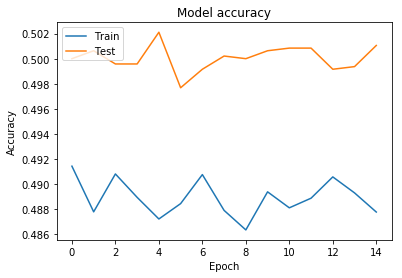

In [9]:
plt.plot(historyE.history['accuracy'])
plt.plot(historyE.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

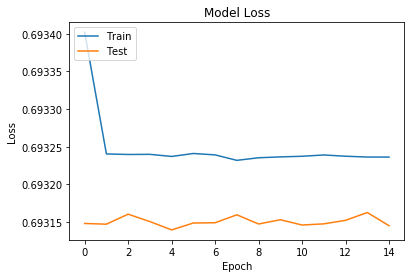

In [10]:
plt.plot(historyE.history['loss'])
plt.plot(historyE.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()